In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import scanpy as sc
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')

In [2]:
import scarches
from scarches.dataset import remove_sparsity
from lataq.models import TRANVAE

# Create reference data without Delta cells and query data with Delta cells

In [3]:
adata = sc.read(os.path.expanduser(
    f'~/Documents/benchmarking_datasets/benchmark_pancreas_shrinked.h5ad'
))
adata

AnnData object with n_obs × n_vars = 16382 × 4000
    obs: 'study', 'cell_type'

In [4]:
condition_key = "study"
cell_type_keys = ["cell_type"]
remove_cts = ["delta"]

reference = ["inDrop1", "inDrop2", "inDrop3", "inDrop4", 
             "fluidigmc1", "smartseq2", "smarter"]
query = ["celseq", "celseq2"]

In [5]:
cell_type_key = cell_type_keys[-1]
adata = remove_sparsity(adata)
ref_adata = adata[adata.obs.study.isin(reference)].copy()
ref_adata = ref_adata[~ref_adata.obs.cell_type.isin(remove_cts)].copy()
query_adata = adata[adata.obs.study.isin(query)].copy()
adata = ref_adata.concatenate(query_adata)

#### Full Data processed

In [6]:
cts = adata.obs[cell_type_key].unique().tolist()
print(adata)
for celltype in cts:
    print(celltype, len(adata[adata.obs.cell_type.isin([celltype])]))

AnnData object with n_obs × n_vars = 15580 × 4000
    obs: 'study', 'cell_type', 'batch'
gamma 699
acinar 1669
alpha 5493
beta 4169
ductal 2142
endothelial 313
activated_stellate 464
schwann 25
mast 42
macrophage 79
epsilon 32
quiescent_stellate 193
t_cell 7
delta 253


#### Reference Data

In [7]:
cts = ref_adata.obs[cell_type_key].unique().tolist()
print(ref_adata)
for celltype in cts:
    print(celltype, len(ref_adata[ref_adata.obs.cell_type.isin([celltype])]))

AnnData object with n_obs × n_vars = 12291 × 4000
    obs: 'study', 'cell_type'
gamma 571
acinar 1167
alpha 4459
beta 3563
ductal 1557
endothelial 287
activated_stellate 355
schwann 20
mast 35
macrophage 63
epsilon 27
quiescent_stellate 180
t_cell 7


#### Query Data

In [8]:
cts = query_adata.obs[cell_type_key].unique().tolist()
print(query_adata)
for celltype in cts:
    print(celltype, len(query_adata[query_adata.obs.cell_type.isin([celltype])]))

AnnData object with n_obs × n_vars = 3289 × 4000
    obs: 'study', 'cell_type'
gamma 128
acinar 502
alpha 1034
delta 253
beta 606
ductal 585
endothelial 26
activated_stellate 109
schwann 5
mast 7
macrophage 16
epsilon 5
quiescent_stellate 13


#### Use the next cell only to simulate a semi labeled reference

# Supervised Reference Training (100% labels used)

In [9]:
tranvae_ref = TRANVAE(
    adata=ref_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_keys,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 7
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 7
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [10]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_landmark_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

tranvae_ref.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=200,
    alpha_epoch_anneal=1e6,
    eta=1,
    clustering_res=2,
)

 |██████████----------| 50.6%  - val_loss: 1001.4149719238 - val_trvae_loss: 1000.7267761230 - val_landmark_loss: 0.6881930530 - val_labeled_loss: 0.6881930530
ADJUSTED LR
 |███████████---------| 59.2%  - val_loss: 996.2891601562 - val_trvae_loss: 995.7532409668 - val_landmark_loss: 0.5359154314 - val_labeled_loss: 0.5359154314
ADJUSTED LR
 |████████████--------| 63.0%  - val_loss: 994.7199340820 - val_trvae_loss: 994.2629089355 - val_landmark_loss: 0.4570267588 - val_labeled_loss: 0.4570267588
ADJUSTED LR
 |████████████--------| 64.4%  - val_loss: 998.2475280762 - val_trvae_loss: 997.8018066406 - val_landmark_loss: 0.4457260460 - val_labeled_loss: 0.44572604608
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 321


# Unsupervised Query Training (0 labels used)

In [11]:
tranvae = TRANVAE.load_query_data(
    adata=query_adata,
    reference_model=tranvae_ref,
    labeled_indices=[],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [12]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

tranvae.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=0,
    eta=1,
    weight_decay=0,
    clustering_res=2,
)

Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1

Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 23 clusters.
 |██████████████------| 73.8%  - val_loss: 1626.5266927083 - val_trvae_loss: 1626.5265706380 - val_landmark_loss: 0.0001088389 - val_unlabeled_loss: 0.1088389034
ADJUSTED LR
 |███████████████-----| 76.6%  - val_loss: 1627.0179850260 - val_trvae_loss: 1627.0178629557 - val_landmark_loss: 0.0001070378 - val_unlabeled_loss: 0.1070378050
ADJUSTED LR
 |████████████████----| 81.8%  - val_loss: 1626.7074788411 - val_trvae_loss: 1626.7073567708 - val_landmark_loss: 0.0001035013 - val_unlabeled_loss: 0.1035012901
ADJUSTED LR
 |█████████████████---| 85.8%  - val_loss: 1628.6905924479 - val_trvae_loss: 1628.6904703776 - val_landmark_loss: 0.0001065621 - val_unlabeled_loss: 0.1065620954
ADJUSTED LR
 |█████████████████---| 87.2%  - val_loss: 1626.806111653

In [13]:
tranvae.save(
    'trained_model',
    overwrite=True
)

# Reloading point if trained model already exists

In [59]:
tranvae = TRANVAE.load(
    dir_path='trained_model',
    adata=query_adata,
)

AnnData object with n_obs × n_vars = 3289 × 4000
    obs: 'study', 'cell_type', 'trvae_size_factors', 'trvae_labeled'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



# Visualizing resulting adata latent representation and landmarks

#### Unlabeled Query Data accuracy

In [60]:
results_dict_q = tranvae.classify(
    metric="gaussian"
)

preds_q = results_dict_q[cell_type_key]['preds']
probs_q = results_dict_q[cell_type_key]['probs']
print(classification_report(
    y_true=query_adata.obs[cell_type_key],
    y_pred=preds_q,
    labels=np.array(query_adata.obs[cell_type_key].unique().tolist())
))

                    precision    recall  f1-score   support

             gamma       0.49      0.98      0.66       128
            acinar       0.99      0.93      0.95       502
             alpha       0.99      0.98      0.98      1034
             delta       0.00      0.00      0.00       253
              beta       0.82      1.00      0.90       606
            ductal       0.93      0.97      0.95       585
       endothelial       1.00      1.00      1.00        26
activated_stellate       0.90      0.99      0.94       109
           schwann       1.00      1.00      1.00         5
              mast       1.00      0.43      0.60         7
        macrophage       1.00      0.94      0.97        16
           epsilon       1.00      0.80      0.89         5
quiescent_stellate       1.00      0.62      0.76        13

         micro avg       0.90      0.90      0.90      3289
         macro avg       0.85      0.82      0.82      3289
      weighted avg       0.85      0.9

/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

#### Semi-Labeled Full Data accuracy

In [61]:
results_dict = tranvae.classify(
    adata.X,
    adata.obs[condition_key],
    metric="gaussian",
)

preds = results_dict[cell_type_key]['preds']
probs = results_dict[cell_type_key]['probs']
print(classification_report(
    y_true=adata.obs[cell_type_key],
    y_pred=preds,
    labels=np.array(adata.obs[cell_type_key].unique().tolist())
))

                    precision    recall  f1-score   support

             gamma       0.84      0.99      0.91       699
            acinar       0.91      0.96      0.93      1669
             alpha       0.99      0.99      0.99      5493
              beta       0.96      0.99      0.98      4169
            ductal       0.96      0.92      0.94      2142
       endothelial       0.99      0.99      0.99       313
activated_stellate       0.96      0.98      0.97       464
           schwann       1.00      0.96      0.98        25
              mast       0.95      0.88      0.91        42
        macrophage       0.99      0.99      0.99        79
           epsilon       0.94      0.97      0.95        32
quiescent_stellate       0.93      0.96      0.94       193
            t_cell       0.78      1.00      0.88         7
             delta       0.00      0.00      0.00       253

          accuracy                           0.96     15580
         macro avg       0.87      0.9

/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

#### Get information for both landmark sets

In [62]:
labeled_set = tranvae.get_landmarks_info(
    metric="gaussian",
)
labeled_set

AnnData object with n_obs × n_vars = 13 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob'

In [63]:
unlabeled_set = tranvae.get_landmarks_info(
    landmark_set='unlabeled',
    metric="gaussian",
)
unlabeled_set

AnnData object with n_obs × n_vars = 23 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob'

#### Create adata object with cell  and landmark informations

In [64]:
data_latent = tranvae.get_latent()
adata_latent = sc.AnnData(data_latent)
adata_latent.obs[condition_key] = query_adata.obs[condition_key].tolist()
adata_latent.obs[cell_type_key] = query_adata.obs[cell_type_key].tolist()
adata_latent.obs[f'{cell_type_key}_pred'] = preds_q.tolist()
adata_latent.obs[f'{cell_type_key}_prob'] = probs_q.tolist()
adata_latent

AnnData object with n_obs × n_vars = 3289 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob'

In [65]:
full_latent = adata_latent.concatenate(labeled_set, unlabeled_set)
full_latent

AnnData object with n_obs × n_vars = 3325 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob', 'batch'

#### Visualize Combined adata object

In [66]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)

/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'study' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_pred' as categorical


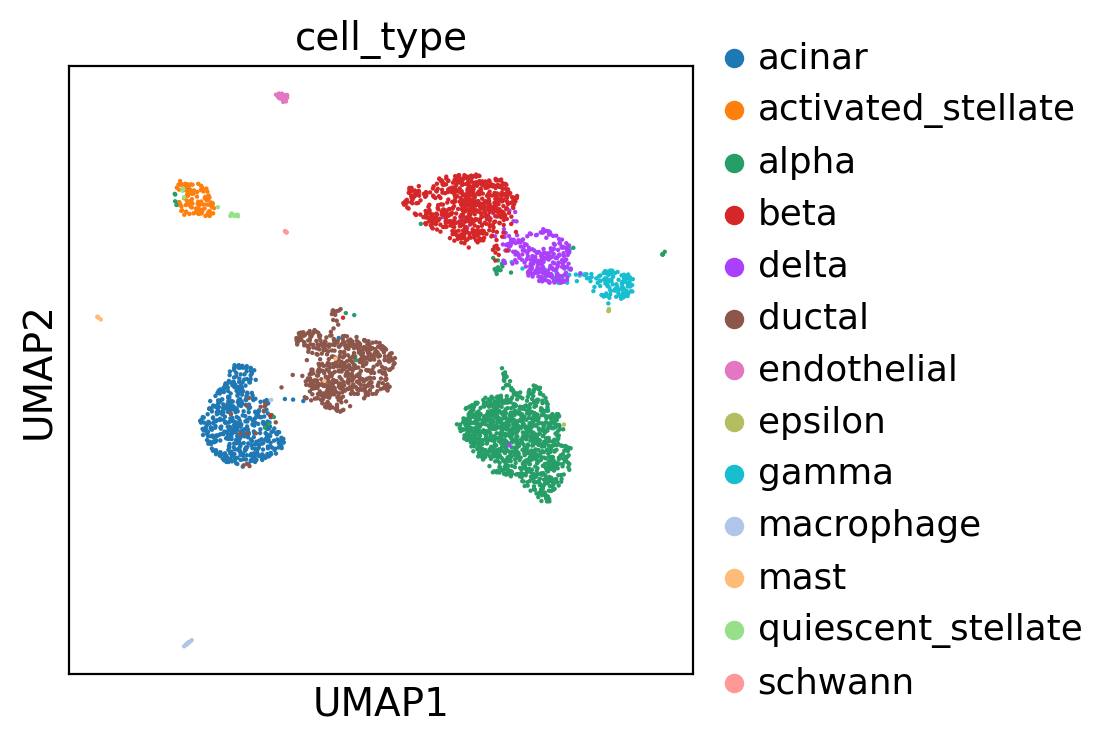

In [67]:
landmark_keys = ["Landmark-Set Unlabeled","Landmark-Set Labeled"]
sc.pl.umap(
    full_latent[~full_latent.obs[condition_key].isin(landmark_keys)],
    size=10,
    color=[cell_type_key],
)

... storing 'study' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_pred' as categorical
Trying to set attribute `.uns` of view, copying.


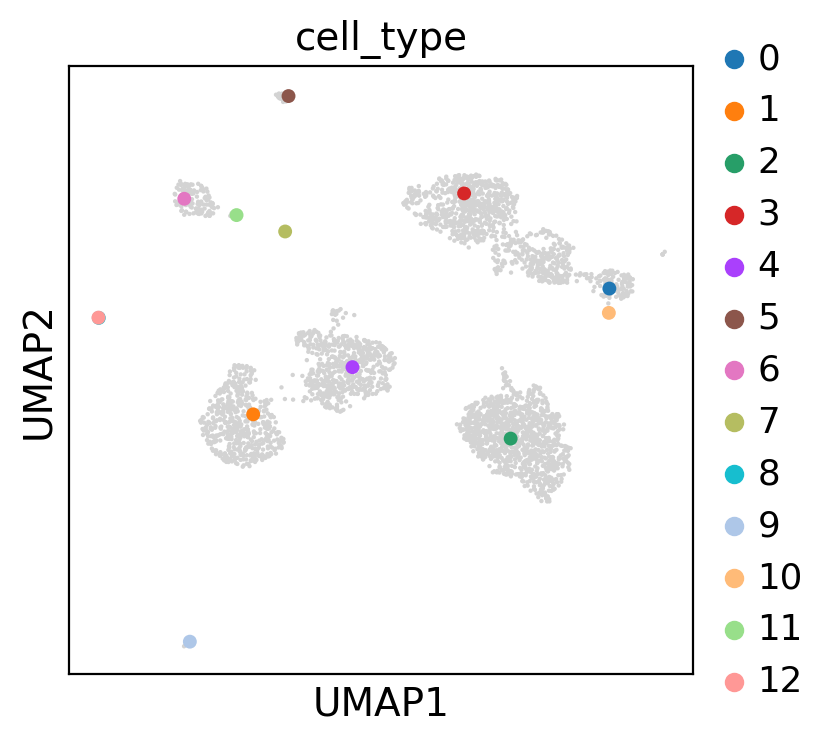

In [68]:
ax = sc.pl.umap(full_latent, size=10, show=False)
sc.pl.umap(
    full_latent[full_latent.obs[condition_key] == "Landmark-Set Labeled"],
    size=100,
    color=[cell_type_key],
    ax=ax
)

Trying to set attribute `.uns` of view, copying.


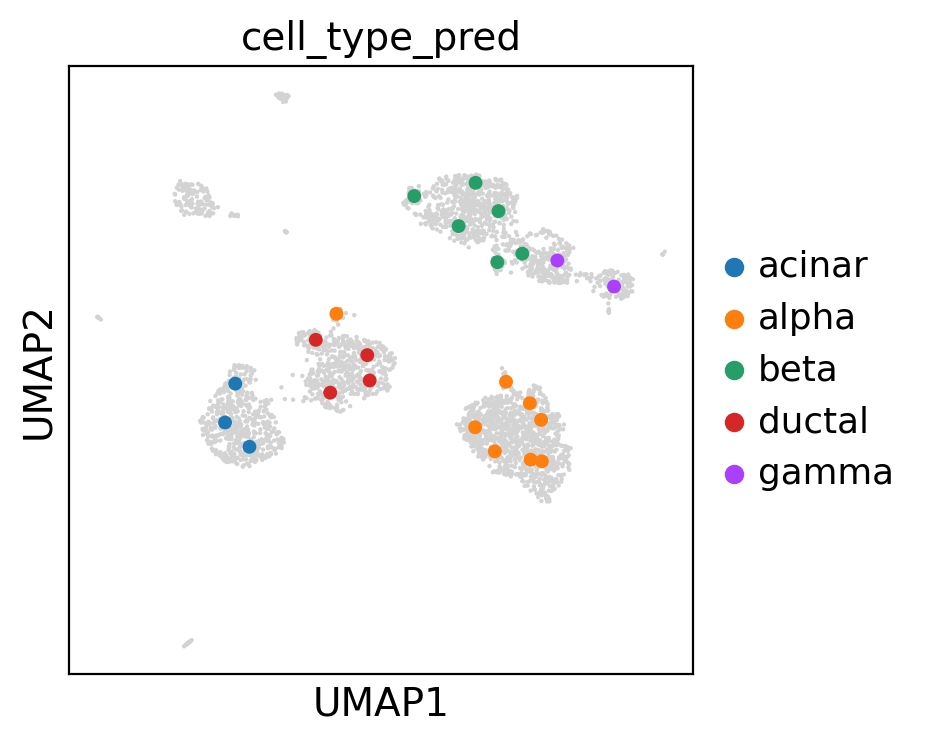

In [69]:
ax = sc.pl.umap(full_latent, size=10, show=False)
sc.pl.umap(
    full_latent[full_latent.obs[condition_key] == "Landmark-Set Unlabeled"],
    size=100,
    color=[cell_type_key + '_pred'],
    ax=ax
)

# Unseen cell type detection

#### Check for novel cell types

In [70]:
print(unlabeled_set.obs["cell_type_prob"])

0     0.996093
1     1.000000
2     1.000000
3     0.992546
4     0.999010
5     1.000000
6     1.000000
7     1.000000
8     1.000000
9     1.000000
10    1.000000
11    1.000000
12    0.999999
13    1.000000
14    1.000000
15    1.000000
16    0.999909
17    1.000000
18    1.000000
19    0.987026
20    1.000000
21    0.868552
22    0.397086
Name: cell_type_prob, dtype: float32


In [71]:
print(unlabeled_set.obs["cell_type_pred"])

0     acinar
1      alpha
2       beta
3     acinar
4      gamma
5      alpha
6      alpha
7       beta
8       beta
9     ductal
10    ductal
11     gamma
12     alpha
13     alpha
14     alpha
15    ductal
16    acinar
17      beta
18     alpha
19      beta
20    ductal
21      beta
22     alpha
Name: cell_type_pred, dtype: object


In [72]:
check = np.array([4,19 ,21])
check_shifted = check + len(adata_latent) + len(labeled_set)

Trying to set attribute `.uns` of view, copying.


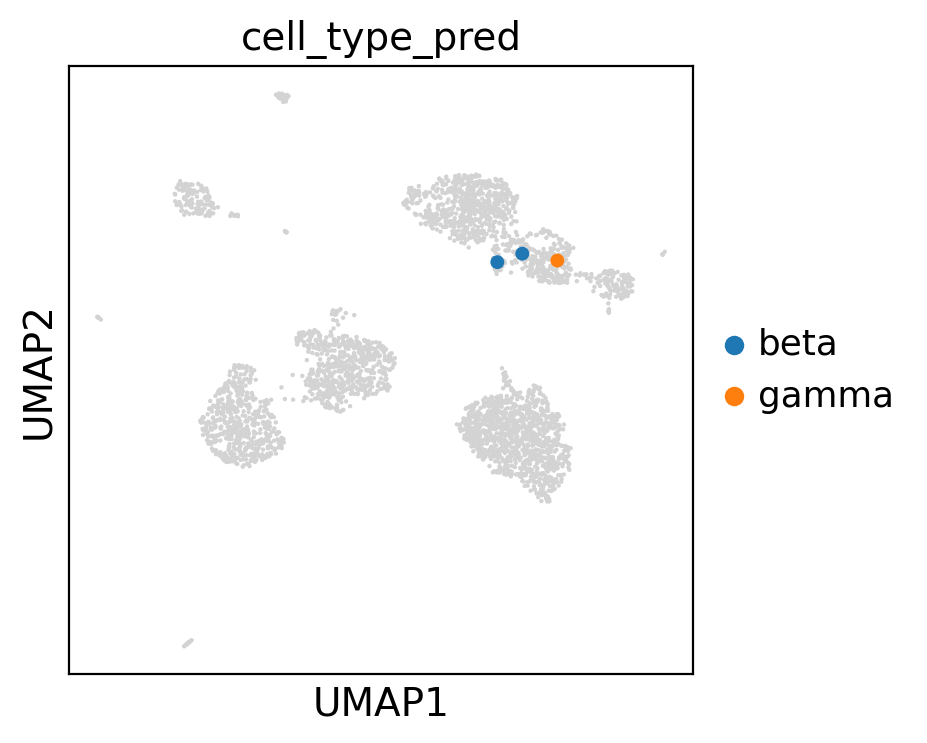

In [73]:
ax = sc.pl.umap(full_latent, size=10, show=False)

sc.pl.umap(
    full_latent[check_shifted],
    size=100,
    color=[cell_type_key + '_pred'],
    ax=ax
)

#### Add novel cell type with corresponding landmark(s) to the model

In [74]:
tranvae.add_new_cell_type(
    "delta", 
    cell_type_key, 
    check.tolist()
)

# Visualize results with updated model

In [75]:
results_dict = tranvae.classify(
    metric="gaussian"
)

preds = results_dict[cell_type_key]['preds']
probs = results_dict[cell_type_key]['probs']
print(classification_report(
    y_true=query_adata.obs[cell_type_key],
    y_pred=preds,
    labels=np.array(query_adata.obs[cell_type_key].unique().tolist())
))

                    precision    recall  f1-score   support

             gamma       0.97      0.88      0.92       128
            acinar       0.99      0.92      0.95       502
             alpha       1.00      0.97      0.98      1034
             delta       0.74      0.98      0.84       253
              beta       0.99      0.93      0.96       606
            ductal       0.92      0.97      0.95       585
       endothelial       1.00      1.00      1.00        26
activated_stellate       0.90      0.99      0.94       109
           schwann       1.00      1.00      1.00         5
              mast       1.00      0.29      0.44         7
        macrophage       1.00      0.94      0.97        16
           epsilon       1.00      0.80      0.89         5
quiescent_stellate       0.89      0.62      0.73        13

         micro avg       0.95      0.95      0.95      3289
         macro avg       0.95      0.87      0.89      3289
      weighted avg       0.96      0.9

In [76]:
labeled_set = tranvae.get_landmarks_info(
    metric="gaussian",
)
unlabeled_set = tranvae.get_landmarks_info(
    landmark_set='unlabeled',
    metric="gaussian",
)
labeled_set

AnnData object with n_obs × n_vars = 14 × 10
    obs: 'study', 'cell_type', 'cell_type_pred', 'cell_type_prob'

In [77]:
results_dict = tranvae.classify(
    adata.X,
    adata.obs[condition_key],
    metric="gaussian",
)

preds = results_dict[cell_type_key]['preds']
probs = results_dict[cell_type_key]['probs']

data_latent = tranvae.get_latent(
    adata.X,
    adata.obs[condition_key],
)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs[condition_key] = adata.obs[condition_key].tolist()
adata_latent.obs[cell_type_key] = adata.obs[cell_type_key].tolist()
adata_latent.obs[f'{cell_type_key}_pred'] = preds.tolist()
adata_latent.obs[f'{cell_type_key}_prob'] = probs.tolist()
full_latent = adata_latent.concatenate(labeled_set, unlabeled_set)

In [78]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)

/home/marco/.pyenv/versions/tranvae/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'study' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type_pred' as categorical


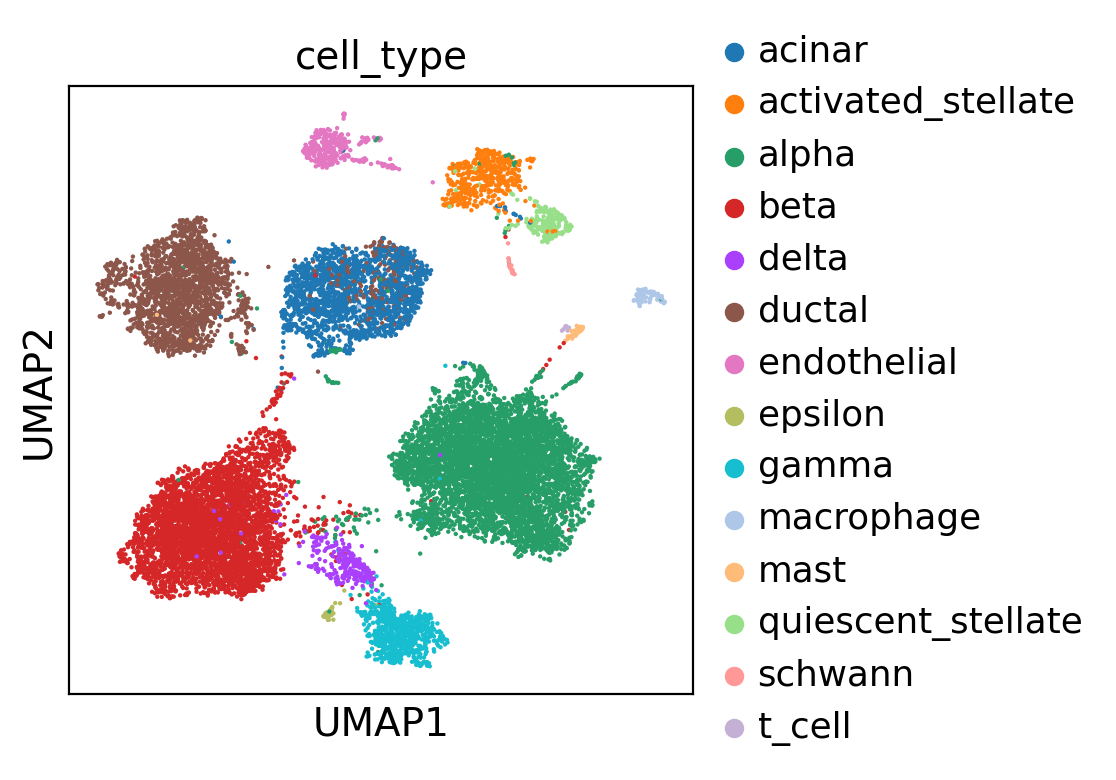

In [79]:
landmark_keys = ["Landmark-Set Unlabeled","Landmark-Set Labeled"]
sc.pl.umap(
    full_latent[~full_latent.obs[condition_key].isin(landmark_keys)],
    size=10,
    color=[cell_type_key],
)

... storing 'study' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_pred' as categorical
Trying to set attribute `.uns` of view, copying.


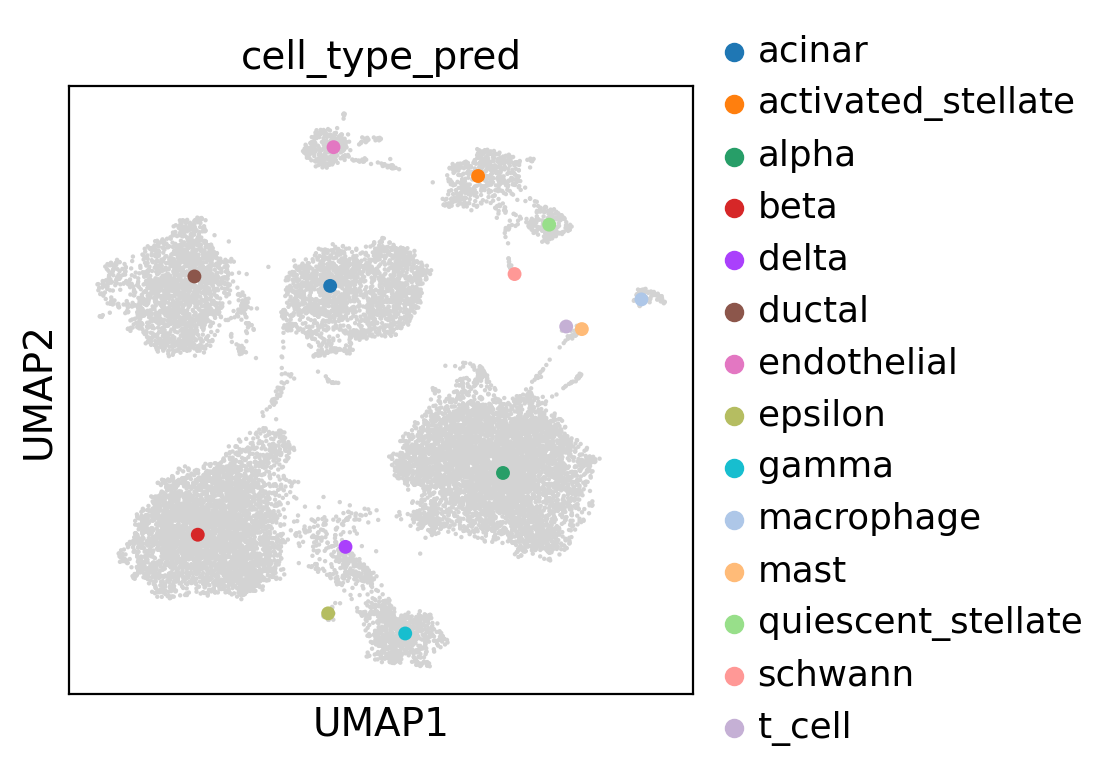

In [80]:
ax = sc.pl.umap(full_latent, size=10, show=False)
sc.pl.umap(
    full_latent[full_latent.obs[condition_key] == "Landmark-Set Labeled"],
    size=100,
    color=[cell_type_key + '_pred'],
    ax=ax
)